<a href="https://colab.research.google.com/github/nprime496/building-floor-recognition/blob/main/code/audio_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

sortie de u-net avec plusieurs channels

## setup

In [13]:
!nvidia-smi

Thu Jul  7 07:58:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8    12W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [14]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T

print(torch.__version__)
print(torchaudio.__version__)

1.11.0+cu113
0.11.0+cu113


In [15]:
import random 
import os

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [17]:
from IPython.display import Audio, display

In [18]:
import librosa


In [19]:
# Define your execution device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [20]:
def seed_all(SEED_VAL=1):
        random.seed(SEED_VAL)
        np.random.seed(SEED_VAL)
        torchaudio.utils.sox_utils.set_seed(SEED_VAL)
        torch.manual_seed(SEED_VAL)
        torch.cuda.manual_seed_all(SEED_VAL)
        os.environ['PYTHONHASHSEED'] = str(SEED_VAL)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [21]:
seed_all(496)

In [22]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
import wandb

wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [26]:
import wandb
assert True,"setup wandb"
#wandb.init(project="my-awesome-project")

## utils

In [27]:
def print_stats(waveform, sample_rate=None, src=None):
  if src:
    print("-" * 10)
    print("Source:", src)
    print("-" * 10)
  if sample_rate:
    print("Sample Rate:", sample_rate)
  print("Shape:", tuple(waveform.shape))
  print("Dtype:", waveform.dtype)
  print(f" - Max:     {waveform.max().item():6.3f}")
  print(f" - Min:     {waveform.min().item():6.3f}")
  print(f" - Mean:    {waveform.mean().item():6.3f}")
  print(f" - Std Dev: {waveform.std().item():6.3f}")
  print()
  print(waveform)
  print()


In [28]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)


In [29]:
def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)


In [30]:

def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].specgram(waveform[c], Fs=sample_rate)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
  figure.suptitle(title)
  plt.show(block=False)


In [31]:
def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")


## Data 

In [32]:
# # Unzip dataset
# !wget https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz -O urban8k.tgz
# !tar -xzf urban8k.tgz
# !rm urban8k.tgz

In [33]:
!cat UrbanSound8K/UrbanSound8K_README.txt

UrbanSound8K

Created By
----------

Justin Salamon*^, Christopher Jacoby* and Juan Pablo Bello*
* Music and Audio Research Lab (MARL), New York University, USA
^ Center for Urban Science and Progress (CUSP), New York University, USA
http://serv.cusp.nyu.edu/projects/urbansounddataset
http://marl.smusic.nyu.edu/
http://cusp.nyu.edu/

Version 1.0


Description
-----------

This dataset contains 8732 labeled sound excerpts (<=4s) of urban sounds from 10 classes: air_conditioner, car_horn, 
children_playing, dog_bark, drilling, engine_idling, gun_shot, jackhammer, siren, and street_music. The classes are 
drawn from the urban sound taxonomy described in the following article, which also includes a detailed description of 
the dataset and how it was compiled:

J. Salamon, C. Jacoby and J. P. Bello, "A Dataset and Taxonomy for Urban Sound Research", 
22nd ACM International Conference on Multimedia, Orlando USA, Nov. 2014.

All excerpts are taken from field recordings uploaded to www.freesou

In [34]:
from torch.utils.data import Dataset

In [35]:
# sample wav for testing purposes
SAMPLE_WAV_PATH="file_example_WAV_1MG.wav"

In [36]:
metadata = torchaudio.info(SAMPLE_WAV_PATH,format="wav")
print(metadata)

AudioMetaData(sample_rate=8000, num_frames=268237, num_channels=2, bits_per_sample=16, encoding=PCM_S)


In [37]:
waveform,sample_rate = torchaudio.load(SAMPLE_WAV_PATH,format="wav")


In [38]:
print_stats(waveform,sample_rate)

Sample Rate: 8000
Shape: (2, 268237)
Dtype: torch.float32
 - Max:      0.941
 - Min:     -0.954
 - Mean:    -0.000
 - Std Dev:  0.150

tensor([[-3.4790e-03, -7.3547e-03, -8.6975e-03,  ..., -2.3560e-02,
         -1.2878e-02, -2.4017e-02],
        [ 7.0190e-04,  9.1553e-05, -8.8501e-04,  ..., -3.2318e-02,
         -2.5635e-02, -9.5825e-03]])



In [39]:
play_audio(waveform,sample_rate)

## Preprocessing

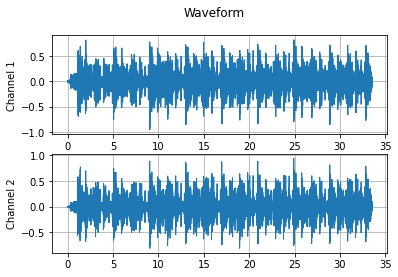

In [40]:
plot_waveform(waveform,sample_rate=sample_rate)

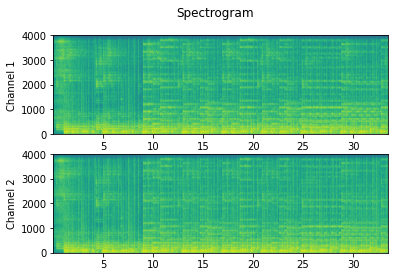

In [41]:
# spectrogram showcase repartition of frequencies in the sample
plot_specgram(waveform,sample_rate)

In [63]:
waveform.shape

torch.Size([2, 268237])

In [72]:
spec.shape

torch.Size([2, 257, 895])

Shape: (2, 257, 895)
Dtype: torch.float32
 - Max:     4206.338
 - Min:      0.000
 - Mean:     4.294
 - Std Dev: 51.890

tensor([[[4.2280e-03, 2.5278e-05, 2.0654e-05,  ..., 1.8656e-01,
          5.6069e-02, 8.9898e-02],
         [2.8648e-03, 8.8971e-05, 5.9083e-05,  ..., 2.9271e-01,
          3.2071e-02, 2.4329e-01],
         [1.1704e-03, 4.4946e-04, 3.4499e-04,  ..., 3.1803e+00,
          5.2959e-01, 5.3959e+00],
         ...,
         [1.6885e-05, 6.6151e-06, 9.2874e-06,  ..., 1.1231e-05,
          3.7074e-07, 5.0439e-04],
         [1.0118e-05, 4.0241e-06, 1.0378e-05,  ..., 9.0736e-06,
          4.0807e-07, 3.9527e-04],
         [6.5903e-06, 4.4670e-06, 5.3806e-06,  ..., 1.0074e-05,
          3.0776e-07, 3.0751e-04]],

        [[1.3183e-03, 5.7160e-06, 4.0862e-05,  ..., 1.3635e-02,
          6.9694e-02, 7.2673e+00],
         [7.4395e-04, 1.3143e-04, 5.2105e-05,  ..., 3.1208e+00,
          2.7104e-01, 1.2909e+01],
         [7.8576e-07, 3.8318e-04, 3.0338e-05,  ..., 2.6607e+00,
       

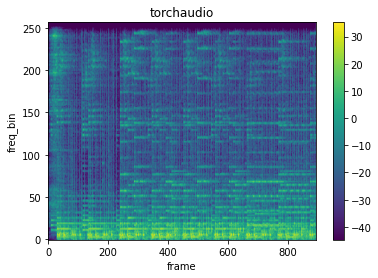

In [89]:
n_fft = 512
win_length = None
hop_length = 300

# define transformation
spectrogram = T.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
)
# Perform transformation
spec = spectrogram(waveform)

print_stats(spec)
plot_spectrogram(spec[0], title='torchaudio')

Shape: (2, 256, 524)
Dtype: torch.float32
 - Max:     203.173
 - Min:     -354.231
 - Mean:     0.394
 - Std Dev: 12.263

tensor([[[-2.8392e+02, -2.5898e+02, -2.3179e+02,  ...,  1.0897e+02,
           2.2764e+01, -4.1402e+01],
         [-4.2393e+00, -1.1460e+01, -3.2111e+01,  ...,  1.0317e+02,
           1.0038e+02,  1.0252e+02],
         [-5.6729e+01, -5.3581e+01, -4.6562e+01,  ...,  2.9147e+01,
           4.4467e+01,  2.8765e+01],
         ...,
         [ 1.2738e+00,  1.1109e+00,  2.2440e+00,  ...,  7.9139e-02,
           1.4939e+00,  1.1803e-01],
         [ 1.6561e+00, -3.0897e+00, -4.4600e+00,  ...,  9.2210e-01,
           2.3269e+00,  5.4715e-01],
         [ 2.3831e+00, -1.2931e+00, -1.7394e+00,  ..., -8.5079e-01,
          -1.9468e+00, -8.0475e-01]],

        [[-3.5423e+02, -3.3511e+02, -3.1073e+02,  ...,  1.0423e+02,
           8.8950e+00, -8.2387e+01],
         [-7.4758e+00, -2.2721e+01, -4.4517e+01,  ...,  1.0188e+02,
           1.0252e+02,  1.1808e+02],
         [-4.0352e+01,

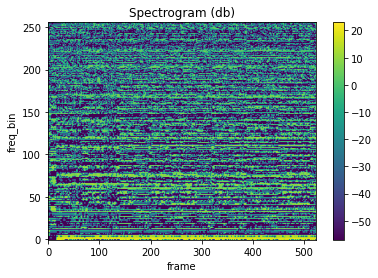

In [43]:

n_fft = 2048
win_length = None
hop_length = 512
n_mels = 256
n_mfcc = 256

mfcc_transform = T.MFCC(
    sample_rate=sample_rate,
    n_mfcc=n_mfcc,
    melkwargs={
      'n_fft': n_fft,
      'n_mels': n_mels,
      'hop_length': hop_length,
      'mel_scale': 'htk',
    }
)

mfcc = mfcc_transform(waveform)
print_stats(mfcc)
plot_spectrogram(mfcc[0])

In [44]:
from torchaudio.transforms import MFCC

In [45]:
def clean_mfcc(data):
  pass

def clean_spectrogram(data):
  pass

## Dataset

### Raw

In [113]:
class SoundDataset(Dataset):
#rapper for the UrbanSound8K dataset
    # Argument List
    #  path to the UrbanSound8K csv file
    #  path to the UrbanSound8K audio files
    #  list of folders to use in the dataset
    
    def __init__(self, csv_path, file_path, folderList):
        csvData = pd.read_csv(csv_path)
        #initialize lists to hold file names, labels, and folder numbers
        self.file_names = []
        self.labels = []
        self.folders = []
        #loop through the csv entries and only add entries from folders in the folder list
        for i in range(0,len(csvData)):
            if csvData.iloc[i, 5] in folderList:
                self.file_names.append(csvData.iloc[i, 0])
                self.labels.append(csvData.iloc[i, 6])
                self.folders.append(csvData.iloc[i, 5])
                
        self.file_path = file_path
         #self.mixer = torchaudio.transforms.DownmixMono() 
        self.folderList = folderList
        
    def __getitem__(self, index):
        #format the file path and load the file
        path = self.file_path + "fold" + str(self.folders[index]) + "/" + self.file_names[index]
        sound = torchaudio.load(path, normalize = True)
        #load returns a tensor with the sound data and the sampling frequency (44.1kHz for UrbanSound8K)

        soundData = torch.mean(sound[0], dim=0).unsqueeze(0) # #UrbanSound8K uses two channels, this will convert them to one
        #downsample the audio to ~8kHz
        tempData = torch.zeros([160000, 1]) #tempData accounts for audio clips that are too short
        if soundData.numel() < 160000:
            tempData[:soundData.numel()] = soundData[:].T
        else:
            tempData[:] = soundData[:,:160000].T
        
        soundData = tempData
        soundFormatted = torch.zeros([32000, 1])
        soundFormatted[:32000] = soundData[::5] #take every fifth sample of soundData
        soundFormatted = soundFormatted.permute(1, 0)
        return soundFormatted, self.labels[index]
    
    def __len__(self):
        return len(self.file_names)


In [114]:
csv_path = './UrbanSound8K/metadata/UrbanSound8K.csv'
file_path = './UrbanSound8K/audio/'

train_set = SoundDataset(csv_path, file_path, range(1,10))
test_set = SoundDataset(csv_path, file_path, [10])
print("Train set size: " + str(len(train_set)))
print("Test set size: " + str(len(test_set)))

kwargs = {'num_workers': 1, 'pin_memory': True} if device == 'cuda' else {} #needed for using datasets on gpu

train_loader = torch.utils.data.DataLoader(train_set, batch_size = 32, shuffle = True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 32, shuffle = True, **kwargs)

Train set size: 7895
Test set size: 837


### Spectrogram

In [115]:
class SpecSoundDataset(SoundDataset):
#rapper for the UrbanSound8K dataset
    # Argument List
    #  path to the UrbanSound8K csv file
    #  path to the UrbanSound8K audio files
    #  list of folders to use in the dataset
    
    def __init__(self, csv_path, file_path, folderList, n_fft, win_length = None, center = True, pad_mode = "reflect", power = 2.0):
        super().__init__(csv_path, file_path, folderList)
        self._n_fft = n_fft
        self._win_length = win_length
        self._hop_length = hop_length
        self._center = center
        self._pad_mode = pad_mode
        self._power = power
        # define transformation
        spectrogram = T.Spectrogram(
          n_fft= self._n_fft,
          win_length=self._win_length,
          hop_length=self._hop_length,
          center=self._center,
          pad_mode=self._pad_mode,
          power=self._power,
        )
        self._spec_mixer = spectrogram
    def __getitem__(self, index):
      soundFormatted, labels= super().__getitem__(index)
      # apply transformation
      return self._spec_mixer(soundFormatted), labels

    
    def __len__(self):
        return len(self.file_names)

In [116]:
train_set[2451][0].shape

torch.Size([1, 32000])

In [117]:
csv_path = './UrbanSound8K/metadata/UrbanSound8K.csv'
file_path = './UrbanSound8K/audio/'

# configure spectrogram settings 
config_spec_args = {
    'n_fft':512,
}

test_train_set = SpecSoundDataset(csv_path, file_path, range(1,10), **config_spec_args)
test_test_set = SpecSoundDataset(csv_path, file_path, [10], **config_spec_args)
print("Train set size: " + str(len(train_set)))
print("Test set size: " + str(len(test_set)))


Train set size: 7895
Test set size: 837


In [94]:
train_set[2451][0].shape

torch.Size([1, 257, 107])

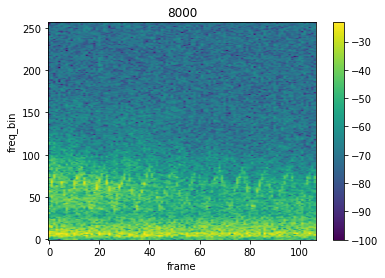

In [98]:
plot_spectrogram(train_set[2451][0][0],8000)

### MFCC

In [119]:
class MFCCSoundDataset(SoundDataset):
#rapper for the UrbanSound8K dataset
    # Argument List
    #  path to the UrbanSound8K csv file
    #  path to the UrbanSound8K audio files
    #  list of folders to use in the dataset
    
    def __init__(self, csv_path, file_path, folderList, n_mfcc, sample_rate, n_fft = None, n_mels = None, mel_scale = 'htk'):
        super().__init__(csv_path, file_path, folderList)
        self._n_fft = n_fft
        self._win_length = win_length
        self._hop_length = hop_length
        self._n_mels = n_mels
        self._n_mfcc = n_mfcc 
        self._sample_rate = sample_rate
        self._mel_scale = mel_scale
        # define transformation
        
        mfcc_transform = T.MFCC(
            sample_rate= self._sample_rate,
            n_mfcc=self._n_mfcc,
            melkwargs={
              'n_fft': self._n_fft,
              'n_mels': self._n_mels,
              'hop_length': self._hop_length,
              'mel_scale': self._mel_scale,
            }
        )

        self._mfcc_transform = mfcc_transform
    def __getitem__(self, index):
      soundFormatted, labels= super().__getitem__(index)
      # apply transformation
      return self._mfcc_transform(soundFormatted), labels

    
    def __len__(self):
        return len(self.file_names)

In [120]:
csv_path = './UrbanSound8K/metadata/UrbanSound8K.csv'
file_path = './UrbanSound8K/audio/'

# configure spectrogram settings 
config_spec_args = {
    'n_fft':512,
    'n_mfcc':20,
    'sample_rate':8000,
    'n_mels':100,

}

test_train_set = MFCCSoundDataset(csv_path, file_path, range(1,10), **config_spec_args)
test_test_set = MFCCSoundDataset(csv_path, file_path, [10], **config_spec_args)
print("Train set size: " + str(len(train_set)))
print("Test set size: " + str(len(test_set)))


Train set size: 7895
Test set size: 837


In [111]:
train_set[2451][0].shape

torch.Size([1, 20, 107])

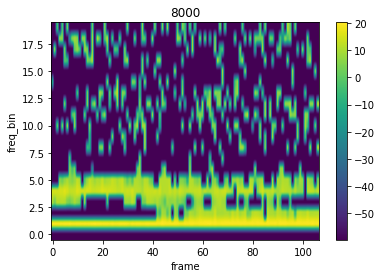

In [112]:
plot_spectrogram(train_set[2451][0][0],8000)

In [123]:
# cleaning 
try:
    del test_train_set
    del test_test_set
except NameError:
    pass

## Models

In [122]:
from torch import nn

In [ ]:
class SimpleNet(nn.Module):
    def __init__(self,in_channels=1,n_output=3):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv1d(in_channels, out_channels = 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool1d(2,2),
        
            nn.Conv1d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv1d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool1d(2,2),
            
            nn.Conv1d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv1d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool1d(2,2),

            nn.Conv1d(256,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool1d(2,2),

            nn.Conv1d(128,32, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool1d(2,2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32000,1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512,n_output)
        )
    
    def forward(self, xb):
        emb = self.network(xb)
        return self.classifier(emb)


In [ ]:
# net=SimpleNet()

In [ ]:
# train_set[0][0].unsqueeze(0).shape

In [ ]:
# conv= nn.Conv1d(1, out_channels = 32, kernel_size = 3, padding = 1)

In [ ]:
4000*256

1024000

In [ ]:
# net(train_set[0][0].unsqueeze(0))

In [ ]:
class MFCCClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    pass

  def __forward(self,X):
    pass

In [ ]:
class Rawlassifier(nn.Module):
  def __init__(self):
    super().__init__()
    pass

  def __forward(self,X):
    pass

In [ ]:
class SpectrogramClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    pass

  def __forward(self,X):
    pass

In [ ]:
class LateFusionClassifier(nn.Module):
  # Model used in late fusion classification
  def __init__(self,estimators,ensemble_model):
    super().__init__()
    self._estimators = [est.copy() for est in estimators]
    self._ensemble = ensemble_model
    pass
  def forward(self,X):
    for i,est in enumerate(self._estimators):
      self._estimators.eval()
      est.forward(X[i]) # concat les resultats
    self._ensemble.forward(X)
  

In [ ]:
class EarlyFusionClassifier(nn.Module):
  def __init__(self,estimators,ensemble_model):
    super().__init__()
    self._estimators = [est.copy() for est in estimators]
    self._ensemble = ensemble_model
    pass
  def forward(self,X):
    for i,est in enumerate(self._estimators):
      self._estimators.eval()
      est.forward(X[i]) # concat les resultats
    self._ensemble.forward(X)
  

## Training

### utils

In [ ]:
from torch.autograd import Variable
from typing import Dict,Any

# Function to save the model
def saveModel(model,path = "./myFirstModel.pth"):
    torch.save(model.state_dict(), path)

# Function to test the model with the test dataset and print the accuracy for the test images
def testAccuracy(model,test_loader,loss_fn):
    
    model.eval()
    accuracy = 0.0
    total = 0.0
    
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            # run the model on the test set to predict labels
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
    
    # compute the accuracy over all test images
    accuracy = (100 * accuracy / total)
    return(loss,accuracy)

class Reporter:
  # proxy used for any reporter ( wandb, tensorboard, etc)
  def __init__(self):
    pass

  def log(self,data:Dict[str, Any]):
    raise NotImplementedError

class WandbReporter(Reporter):
  def __init__(self,wandb):
    self._wandb=wandb
    super().__init__()
  
  def log(self,data:Dict[str, Any]):
    self._wandb.log(kwargs)



# Training function. We simply have to loop over our data iterator and feed the inputs to the network and optimize.
def train(model,train_loader,optimizer,loss_fn,eval_loader=None,num_epochs = 10,train_steps=1000,eval_steps=1000,device=torch.device("cpu"),reporter=None):
    
    best_accuracy = 0.0


    print("The model will be running on", device, "device")
    # Convert model parameters and buffers to CPU or Cuda
    model.to(device)

    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        running_acc = 0.0

        for i, (images, labels) in enumerate(train_loader, 0):
            
            # get the inputs
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))

            # zero the parameter gradients
            optimizer.zero_grad()
            # predict classes using images from the training set
            outputs = model(images)
            # compute the loss based on model output and real labels
            loss = loss_fn(outputs, labels)
            # backpropagate the loss
            loss.backward()
            # adjust parameters based on the calculated gradients
            optimizer.step()

            # Let's print statistics for every 1,000 images
            running_loss += loss.item()     # extract the loss value
            if i % (train_steps) == (train_steps-1):    
                # print every 1000 (twice per epoch) 
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / train_steps))
                if reporter:
                    reporter.log({'training loss':running_loss})
                # zero the loss
                running_loss = 0.0


        # Compute and print the average accuracy fo this epoch when tested over all 10000 test images
        eval_loss, accuracy = testAccuracy(model,eval_loader)
        print('Epoch[', epoch+1,'] eval accuracy %d %%' % (accuracy),"eval loss %d %%" % (eval_loss))
        if reporter:
          reporter.log({'eval loss':eval_loss,'eval accuracy':accuracy})
        
        # we want to save the model if the accuracy is the best
        if accuracy > best_accuracy:
            saveModel(model)
            best_accuracy = accuracy

### Direct model training

In [ ]:
net = SimpleNet(in_channels=1,n_output=10)
rate_learning = 3e-4

In [ ]:
net

SimpleNet(
  (network): Sequential(
    (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU()
    (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (6): ReLU()
    (7): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (8): ReLU()
    (9): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (11): ReLU()
    (12): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (13): ReLU()
    (14): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (16): ReLU()
    (17): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (18): Conv1d(

In [ ]:

model = net
param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('Approximated model size: {:.3f}MB'.format(size_all_mb))

Approximated model size: 128.881MB


In [ ]:
optimizer = torch.optim.Adam(net.parameters(), lr=rate_learning)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
train(net,train_loader,optimizer,loss_fn,eval_loader=test_loader,num_epochs = 2,train_steps=10,device=device)

The model will be running on cuda:0 device
[1,    10] loss: 2.300
[1,    20] loss: 2.273
[1,    30] loss: 2.271
[1,    40] loss: 2.274
[1,    50] loss: 2.268
[1,    60] loss: 2.264
[1,    70] loss: 2.270
[1,    80] loss: 2.257
[1,    90] loss: 2.273
[1,   100] loss: 2.271
[1,   110] loss: 2.275
[1,   120] loss: 2.265
[1,   130] loss: 2.276
[1,   140] loss: 2.252
[1,   150] loss: 2.250
[1,   160] loss: 2.257
[1,   170] loss: 2.276
[1,   180] loss: 2.262
[1,   190] loss: 2.269
